# Implementation of the front door criterion with usage examples

First we install and import some useful Python libraries

In [ ]:
%%capture
!pip install networkx numpy pandas statsmodels

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing import Set, List
from itertools import chain, combinations

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We define a function to compute the augmented causal graph, namely, given a causal graph and a variable, we remove all its outgoing edges

In [ ]:
def augmented_graph(graph: nx.DiGraph, x: Set[str]):
    g_copy = graph.copy()
    for _X in x:
        for _L in {*g_copy.successors(_X)}:
            g_copy.remove_edge(_X, _L)
    return g_copy

We define a function that checks if there is a backdoor path in the augmented causal graph between two variables by conditioning on a adjustment set

In [ ]:
def has_backdoor_paths(graph: nx.DiGraph, x: Set[str], y: Set[str], adjustment_set: Set[str]) -> bool:
    if x & y or x & adjustment_set or y & adjustment_set:
        raise Exception("X, Y and Z have to be disjointed.")
    graph_augmented = augmented_graph(graph, x)
    return not nx.d_separated(graph_augmented, x, y, adjustment_set)

We define a function that checks that an adjustment set intercepts all direct paths between two variables

In [ ]:
def is_interceptor(graph: nx.DiGraph, x: str, y: str, adjustment_set: Set[str]) -> bool:
    g_copy = graph.copy()
    for _M in adjustment_set:
        g_copy.remove_node(_M)
    return not nx.has_path(g_copy, x, y)

We compose the above functions to check that an adjustment set meets the Front Door Criterion

In [ ]:
def is_front_door_adjustment_set(graph: nx.DiGraph, x: str, y: str, adjustment_set: Set[str]) -> bool:
    # the adjustment set has to be descendant of X
    if adjustment_set & nx.ancestors(graph, x):
        return False
    # checks if the adjustment set intercepts all paths between X and Y
    if not is_interceptor(graph, x, y, adjustment_set):
        return False
    # check that from X to the adjustment set there are no backdoor paths
    if has_backdoor_paths(graph, {x}, adjustment_set, set()):
        return False
    # check that from the adjustment set to Y given X there are no backdoor paths
    return not has_backdoor_paths(graph.copy(), adjustment_set, {y}, {x})

Given a graph, a treatment variable, and an outcome variable, we define a function to compute what is the adjustment set that satisfies the Front Door Criterion. In order to accomplish this task, we use the power set of the descendants of the treatment variable (excluding the outcome variable)

In [ ]:
def find_front_door_adjustment_set(graph: nx.DiGraph, x: str, y: str) -> List:
    # we consider only the power set of the descendants of x
    descendants_of_x = nx.descendants(graph, x)
    # we remove Y from the descendant of X
    descendants_of_x.remove(y)
    power_set_of_descendants_of_x = chain.from_iterable(
        combinations(descendants_of_x, r) for r in range(len(descendants_of_x) + 1))
    # we order the power set according to cardinality
    power_set_of_descendants_of_x = sorted(power_set_of_descendants_of_x, key=len)
    # we look for the smallest set that meets the front door criterion
    i = 0
    found = False
    adjustment_set = set()
    while not found and i < len(power_set_of_descendants_of_x):
        if is_front_door_adjustment_set(graph, x, y, set(power_set_of_descendants_of_x[i])):
            found = True
            adjustment_set = set(power_set_of_descendants_of_x[i])
        i += 1
    return [adjustment_set, found]

We define a linear regression as a prediction model

In [ ]:
def linear_model(_data: pd.DataFrame, x: str, y: str, adjustment_set: Set[str]):
    formula = f"{y} ~ {x}"
    if len(adjustment_set) != 0:
        formula += "+" + "+".join(adjustment_set)
    estimator = sm.OLS.from_formula(formula, _data).fit()
    Y1 = estimator.predict(_data.assign(**{x: 1}))
    Y0 = estimator.predict(_data.assign(**{x: 0}))
    return np.mean(Y1 - Y0)

We use the linear regression model and the functions defined above to find the adjustment set and compute the average causal effect (ACE)

In [ ]:
def compute_causal_effect_with_front_door_criterion(_data: pd.DataFrame, graph: nx.DiGraph, x: str, y: str):
    adjustment_set, found = find_front_door_adjustment_set(graph, x, y)
    if found:
        print("adjustment set found: ", adjustment_set)
        _effect = np.zeros(len(adjustment_set))
        i = 0
        # We compute for each variable K in the adjustment set the effect from X to Y
        for k in adjustment_set:
            _effect[i] = linear_model(_data, x=x, y=k, adjustment_set=set()) * \
                         linear_model(_data, x=k, y=y, adjustment_set={x})
            i = i + 1
        # The estimated effects for the different paths are summed up
        return np.sum(_effect)
    else:
        raise Exception("No adjustment set found.")

# TESTS

## Test 1
*Exogenous variables:*  
U_i ∼ $N(0, 1)$  
Z_i ∼ $U(0, 1)$  
e_X_i ∼ $N(0, 1)$   
e_M_i ∼ $N(0, 1)$  
e_Y_i ∼ $N(0, 1)$  
*Endogenous variables:*  
X_i = $0.5$ $\times$ U_i $+$ e_X_i  
M_i = Z_i $\times$ X_i $+$ e_M_i  
Y_i = $0.5$ $\times$ M_i + $0.5$ $\times$ U_i + e_Y_i  
  
$ACE = 0.25$


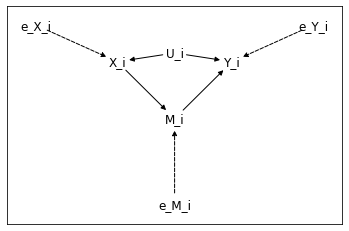

In [ ]:
G = nx.DiGraph()
E_U = [("e_Y_i", "Y_i"), ("e_M_i", "M_i"), ("e_X_i", "X_i")]
E_V = [("U_i", "Y_i"), ("U_i", "X_i"), ("M_i", "Y_i"), ("X_i", "M_i")]
G.add_edges_from(E_U + E_V)
pos = nx.spectral_layout(G)
_ = nx.draw_networkx_labels(G, pos)
sty = {"min_source_margin": 12, "min_target_margin": 12}
_ = nx.draw_networkx_edges(G, pos, E_U, style="dashed", **sty)
_ = nx.draw_networkx_edges(G, pos, E_V, style="solid", **sty)

In [ ]:
def sample_data_1(size: int = int(1e6), seed: int = 31):
    np.random.seed(seed)
    U_i = np.random.normal(0, 1, size)
    Z_i = np.random.uniform(0, 1, size)
    e_X_i = np.random.normal(0, 1, size)
    e_M_i = np.random.normal(0, 1, size)
    e_Y_i = np.random.normal(0, 1, size)
    X_i = 0.5 * U_i + e_X_i
    M_i = Z_i * X_i + e_M_i
    Y_i = 0.5 * M_i + 0.5 * U_i + e_Y_i
    return pd.DataFrame(
        {"X_i": X_i, "M_i": M_i, "Y_i": Y_i, "U_i": U_i, "Z_i": Z_i, "e_X_i": e_X_i, "e_M_i": e_M_i, "e_Y_i": e_Y_i})

In [ ]:
data = sample_data_1(size=100000)
data.describe()

,X_i,M_i,Y_i,U_i,Z_i,e_X_i,e_M_i,e_Y_i
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001383,0.000353,0.004723,0.004124,0.498521,-0.000680,-0.001547,0.002484
std,1.116569,1.186440,1.315898,1.000207,0.288103,0.997453,0.996324,1.000675
min,-4.836180,-5.511756,-5.705977,-4.403123,0.000011,-4.765363,-4.033464,-4.086344
25%,-0.750513,-0.782182,-0.879063,-0.675004,0.249577,-0.675101,-0.677340,-0.676014
50%,0.002238,0.002609,0.010672,0.004771,0.497169,-0.000424,0.001906,0.002782
75%,0.754918,0.783677,0.889836,0.683239,0.746675,0.673617,0.668666,0.678988
max,4.595810,5.726765,5.956485,4.445709,0.999998,4.288078,4.136374,4.023876


In [ ]:
true_ace = 0.25

effect = compute_causal_effect_with_front_door_criterion(data, G, "X_i", "Y_i")

print(f"Estimated ACE: {effect:.3}, Real ACE: {true_ace:.3}, Relative Error: {(np.abs(((effect - true_ace) / true_ace) * 100)):.4}%")

adjustment set found:  {'M_i'}
Estimated ACE: 0.25, Real ACE: 0.25, Relative Error: 0.1597%


## TEST 2  
*Exogenous variables:*  
U_i ∼ $N(0, 1)$  
Z_1_i ∼ $U(0, 1)$  
Z_2_i ∼ $U(0, 1)$  
e_X_i ∼ $N(0, 1)$   
e_M_1_i ∼ $N(0, 1)$  
e_M_2_i ∼ $N(0, 1)$  
e_Y_i ∼ $N(0, 1)$  
*Endogenous variables:*  
X_i = $0.5$ $\times$ U_i $+$ e_X_i  
M_1_i = Z_1_i $\times$ X_i $+$ e_M_1_i  
M_2_i = Z_2_i $\times$ X_i $+$ e_M_2_i  
Y_i = $0.5$ $\times$ M_1_i $+$ $0.5$ $\times$ M_2_i $+$ $0.5$ $\times$ U_i $+$ e_Y_i  
  
$ACE = 0.50$

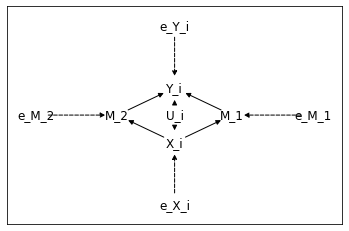

In [ ]:
G = nx.DiGraph()
E_U = [("e_Y_i", "Y_i"), ("e_M_1", "M_1"), ("e_M_2", "M_2"), ("e_X_i", "X_i")]
E_V = [("U_i", "Y_i"), ("U_i", "X_i"), ("M_1", "Y_i"), ("M_2", "Y_i"), ("X_i", "M_1"), ("X_i", "M_2")]
G.add_edges_from(E_U + E_V)
pos = nx.spectral_layout(G)
_ = nx.draw_networkx_labels(G, pos)
sty = {"min_source_margin": 12, "min_target_margin": 12}
_ = nx.draw_networkx_edges(G, pos, E_U, style="dashed", **sty)
_ = nx.draw_networkx_edges(G, pos, E_V, style="solid", **sty)

In [ ]:
def sample_data_2(size: int = int(1e6), seed: int = 31):
    np.random.seed(seed)
    U_i = np.random.normal(0, 1, size)
    Z_1_i = np.random.uniform(0, 1, size)
    Z_2_i = np.random.uniform(0, 1, size)
    e_X_i = np.random.normal(0, 1, size)
    e_M_1 = np.random.normal(0, 1, size)
    e_M_2 = np.random.normal(0, 1, size)
    e_Y_i = np.random.normal(0, 1, size)
    X_i = 0.5 * U_i + e_X_i
    M_1 = Z_1_i * X_i + e_M_1
    M_2 = Z_2_i * X_i + e_M_2
    Y_i = 0.5 * M_1 + 0.5 * M_2 + 0.5 * U_i + e_Y_i
    return pd.DataFrame(
        {"X_i": X_i, "M_1": M_1, "M_2": M_2, "Y_i": Y_i, "U_i": U_i, "Z_1_i": Z_1_i, "Z_2_i": Z_2_i, "e_X_i": e_X_i, "e_M_1": e_M_1, "e_M_2": e_M_2,"e_Y_i": e_Y_i})

In [ ]:
data = sample_data_2(size=100000)
data.describe()

,X_i,M_1,M_2,Y_i,U_i,Z_1_i,Z_2_i,e_X_i,e_M_1,e_M_2,e_Y_i
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001523,0.003372,-0.004229,0.003002,0.004124,0.498521,0.498737,-0.000539,0.003015,-0.005354,0.001368
std,1.116959,1.193685,1.185363,1.539453,1.000207,0.288103,0.288317,0.997395,0.999637,0.997478,0.997490
min,-5.023345,-6.065012,-5.526938,-7.370759,-4.403123,0.000011,0.000063,-4.765363,-4.086344,-4.278671,-3.974191
25%,-0.754404,-0.785283,-0.781397,-1.023012,-0.675004,0.249577,0.248844,-0.676512,-0.674876,-0.674179,-0.670965
50%,0.003791,0.001936,-0.002604,0.005214,0.004771,0.497169,0.499935,0.003182,0.000417,-0.003598,0.004538
75%,0.759114,0.796426,0.773640,1.031438,0.683239,0.746675,0.748079,0.673993,0.677311,0.662947,0.673895
max,4.592644,5.583888,5.916629,7.739766,4.445709,0.999998,0.999995,4.136374,4.025357,4.471917,4.108962


In [ ]:
true_ace = 0.50

effect = compute_causal_effect_with_front_door_criterion(data, G, "X_i", "Y_i")

print(f"Estimated ACE: {effect:.3}, Real ACE: {true_ace:.3}, Relative Error: {(np.abs(((effect - true_ace) / true_ace) * 100)):.4}%")

adjustment set found:  {'M_2', 'M_1'}
Estimated ACE: 0.504, Real ACE: 0.5, Relative Error: 0.7112%


## TEST 3  
*Exogenous variables:*  
U_i ∼ $N(0, 1)$  
Z_1_i ∼ $U(0, 1)$  
Z_2_i ∼ $U(0, 1)$  
e_X_i ∼ $N(0, 1)$   
e_M_1_i ∼ $N(0, 1)$  
e_M_2_i ∼ $N(0, 1)$  
e_Y_i ∼ $N(0, 1)$  
*Endogenous variables:*  
X_i = $0.5$ $\times$ U_i $+$ e_X_i  
M_1_i = Z_1_i $\times$ X_i $+$ e_M_1_i  
M_2_i = Z_2_i $\times$ X_i $+$ e_M_2_i  
Y_i = $0.5$ $\times$ M_1_i $+$ $0.5$ $\times$ M_2_i $+$ $0.5$ $\times$ U_i $+$ e_Y_i  
  
$ACE = 0.125$

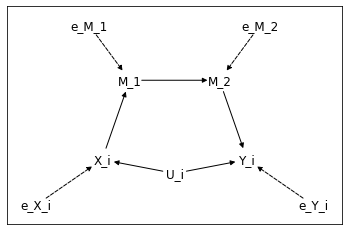

In [ ]:
G = nx.DiGraph()
E_U = [("e_Y_i", "Y_i"), ("e_M_1", "M_1"), ("e_M_2", "M_2"), ("e_X_i", "X_i")]
E_V = [("U_i", "Y_i"), ("U_i", "X_i"), ("M_2", "Y_i"), ("X_i", "M_1"), ("M_1", "M_2")]
G.add_edges_from(E_U + E_V)
pos = nx.spectral_layout(G)
_ = nx.draw_networkx_labels(G, pos)
sty = {"min_source_margin": 12, "min_target_margin": 12}
_ = nx.draw_networkx_edges(G, pos, E_U, style="dashed", **sty)
_ = nx.draw_networkx_edges(G, pos, E_V, style="solid", **sty)

In [ ]:
def sample_data_3(size: int = int(1e6), seed: int = 31):
    np.random.seed(seed)
    U_i = np.random.normal(0, 1, size)
    Z_1_i = np.random.uniform(0, 1, size)
    Z_2_i = np.random.uniform(0, 1, size)
    e_X_i = np.random.normal(0, 1, size)
    e_M_1 = np.random.normal(0, 1, size)
    e_M_2 = np.random.normal(0, 1, size)
    e_Y_i = np.random.normal(0, 1, size)
    X_i = 0.5 * U_i + e_X_i
    M_1 = Z_1_i * X_i + e_M_1
    M_2 = Z_2_i * M_1 + e_M_2
    Y_i = 0.5 * M_2 + 0.5 * U_i + e_Y_i
    return pd.DataFrame(
        {"X_i": X_i, "M_1": M_1, "M_2": M_2, "Y_i": Y_i, "U_i": U_i, "Z_1_i": Z_1_i, "Z_2_i": Z_2_i, "e_X_i": e_X_i, "e_M_1": e_M_1, "e_M_2": e_M_2,"e_Y_i": e_Y_i})

In [ ]:
data = sample_data_3(size=100000)
data.describe()

,X_i,M_1,M_2,Y_i,U_i,Z_1_i,Z_2_i,e_X_i,e_M_1,e_M_2,e_Y_i
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001523,0.003372,-0.000829,0.003016,0.004124,0.498521,0.498737,-0.000539,0.003015,-0.005354,0.001368
std,1.116959,1.193685,1.210960,1.296466,1.000207,0.288103,0.288317,0.997395,0.999637,0.997478,0.997490
min,-5.023345,-6.065012,-6.118590,-6.267251,-4.403123,0.000011,0.000063,-4.765363,-4.086344,-4.278671,-3.974191
25%,-0.754404,-0.785283,-0.794176,-0.868039,-0.675004,0.249577,0.248844,-0.676512,-0.674876,-0.674179,-0.670965
50%,0.003791,0.001936,0.002172,0.003874,0.004771,0.497169,0.499935,0.003182,0.000417,-0.003598,0.004538
75%,0.759114,0.796426,0.788475,0.874441,0.683239,0.746675,0.748079,0.673993,0.677311,0.662947,0.673895
max,4.592644,5.583888,6.127652,6.339901,4.445709,0.999998,0.999995,4.136374,4.025357,4.471917,4.108962


In [ ]:
true_ace = 0.125

effect = compute_causal_effect_with_front_door_criterion(data, G, "X_i", "Y_i")

print(f"Estimated ACE: {effect:.3}, Real ACE: {true_ace:.3}, Relative Error: {(np.abs(((effect - true_ace) / true_ace) * 100)):.4}%")

adjustment set found:  {'M_2'}
Estimated ACE: 0.127, Real ACE: 0.125, Relative Error: 1.58%
